In [1]:
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
import statsmodels.regression.quantile_regression as smqr

def generate_noisy_homosckedastic_sin(n, noise, n_pi):
  noise = np.random.normal(0,1,n) * noise
  sin = np.sin(np.linspace(0, n_pi*np.pi, n))

  res = noise + sin
  return (np.linspace(0, n_pi*np.pi, n), res)

def generate_noisy_heterosckedastic_sin(n, noise, n_pi, hetero_factor):
  cosin = np.cos(np.linspace(0, n_pi*np.pi*hetero_factor, n))
  add_noise = np.random.normal(0,1,n) * noise * cosin
  sinwave = np.sin(np.linspace(0, n_pi*np.pi, n))

  res = add_noise + sinwave
  return (np.linspace(0, n_pi*np.pi, n), res)

def sliding_window(data, seq_len, horizon):
  x = []
  y = []
  for i in range(len(data) - seq_len - horizon):
    x.append(data[i: i + seq_len])
    y.append(data[i + seq_len: i+seq_len + horizon])
  return np.array(x), np.array(y)

def train_test_split(X, Y, test_size):
  X_train = X[:-test_size]
  Y_train = Y[:-test_size]
  X_test = X[-test_size:]
  Y_test = Y[-test_size:]
  return X_train, Y_train, X_test, Y_test

In [4]:
import scipy as scp
def  sample_from_quantiles(df_y_pred_q, quantiles, n_scenarios, cov_matrix = [], rnd_seed = [], sort = "No", debug=False):
    n_periods = np.size(df_y_pred_q,0)
    
    if np.size(cov_matrix,0) == 0:
        cov_matrix = np.identity(n_periods)
    if np.size(rnd_seed,0) != 0:        
        np.random.seed(rnd_seed)

    
    mean_vector = np.zeros(n_periods)
    std_vector = np.sqrt(np.diagonal(cov_matrix))
    
    # Normalize covariance matrix    
    cov_matrix = cov_matrix / np.outer(std_vector,std_vector)
    if debug:
        print('covariance matrix')
        print(cov_matrix)
    
    # Generate multivariate Gaussian random numbers with zero mean and covariance matrix
    X = np.random.multivariate_normal(mean_vector, cov_matrix, n_scenarios)
    # Sort
    if sort == "Yes": 
        X = np.sort(X, axis=0)
    # Gaussian --> Uniform transformation
    Y = scp.stats.norm.cdf(X)
    
    # Plot hist of X (normal) and Y(uniform)
    if debug:
        bin_cnt = 200
        plt.hist(X[:,0],bin_cnt)
        plt.show()
        plt.hist(Y[:,0],bin_cnt)
        plt.show()

    # Calculate interpolation function
    Finv = scp.interpolate.interp1d(quantiles, df_y_pred_q, kind='quadratic', axis=1, bounds_error=False, fill_value="extrapolate")
    
   
    columns = ['scenario{0}'.format(int(i)) for i in range(n_scenarios)]
    scenarios = pd.DataFrame(index=df_y_pred_q.index, columns=columns)
    for i in range(n_periods):
        scenarios.iloc[i] = Finv(Y[:,i])[i,:]
    
    
    # Print CDF and scenarios    
    if debug:
        for i in range(n_periods):
            plt.plot(df_y_pred_q.iloc[i], quantiles, 'o', scenarios.iloc[i], Y[:,i], 'x')
            plt.show()
   
    return scenarios


def  update_cov_matrix(df_y_pred_q, quantiles, actual_data, forget_factor, cov_matrix, debug=False):
    """
    df_y_pred_q (n_period, n_quantiles) where n_period represents each time step on the horizon
                 
    
    """
    
    n_periods = df_y_pred_q.shape[1]
    
    Y = np.zeros(n_periods)
    for i in range(n_periods):   
        Finv = scp.interpolate.interp1d(df_y_pred_q[:,i], quantiles, kind='linear', bounds_error=False, fill_value="extrapolate")
        Y[i] = min(0.99999, max(0.00001,Finv(actual_data[i]))) # Apply lower (0) and upper (1) limits
    
    X = scp.stats.norm.ppf(Y) 
        
    cov_matrix = forget_factor * cov_matrix + (1-forget_factor) * np.outer(X,X)
    
    # Normalize covariance matrix    
    std_vector = np.sqrt(np.diagonal(cov_matrix))
    cov_matrix = cov_matrix / np.outer(std_vector,std_vector)
    
    if debug:
        print('covariance matrix')
        print(cov_matrix)
    
    return cov_matrix

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

class TimeSeriesData:
    def __init__(self, num_datapoints, test_size=50, max_t=20, num_prev=1,
                 noise_var=1):
        """
        Template class for generating time series data.
        :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
        """
        self.num_datapoints = num_datapoints
        self.test_size = test_size
        self.num_prev = num_prev
        self.max_t = max_t
        self.data = None
        self.noise_var = noise_var
        self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
        self.bayes_preds = np.copy(self.y)

        # Generate data and reshape data
        self.create_data()

        # Split into training and test sets
        self.train_test_split()

    def create_data(self):
        self.generate_data()
        self.reshape_data()

    def generate_data(self):
        """Generates data in self.y, may take as implicit input timesteps self.t.
        May also generate Bayes predictions."""
        raise NotImplementedError("Generate data method not implemented.")

    def reshape_data(self):
        self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
            self.num_datapoints)], (-1, self.num_prev))
        self.y = np.copy(self.y[self.num_prev:])
        self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

    def train_test_split(self):
        test_size = self.test_size
        
        self.data = [self.X_train, self.X_test, self.y_train,
                     self.y_test] = \
                    self.x[:-test_size], self.x[-test_size:], \
                    self.y[:-test_size], self.y[-test_size:]
        self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]
        
    def return_data(self):
        return self.data

    def return_train_test(self):
        return self.X_train, self.y_train, self.X_test, self.y_test
    
    def transform_xy_to_multistep(X, y, h):
    res_x = np.empty([(X.shape[0] - h) * h , X.shape[1] + 1])
    res_y = np.empty([(y.shape[0] - h) * h ])

    for i in range(X.shape[0] - h):
        res_x[i * h: i * h + h, 0:X.shape[1]] = np.tile(X[i],(h,1))
        res_x[i * h: i * h + h, X.shape[1]] = np.arange(h)/h

        res_y[i * h: i * h + h] = y[i:i+h]
    return res_x, res_y

class ARData(TimeSeriesData):
    """Class to generate autoregressive data."""
 
    def __init__(self, *args, coeffs=None, **kwargs):
        self.given_coeffs = coeffs
        super(ARData, self).__init__(*args, **kwargs)
 
        if coeffs is not None:
            self.num_prev = len(coeffs) - 1
 
    def generate_data(self):
        self.generate_coefficients()
        self.generate_initial_points()
 
        # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
        # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
        for i in range(self.num_datapoints+3*self.num_prev):
            # Generate y value if there was no noise
            # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
            self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
            # Add noise
            self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()
 
        # Cut first 20 points so dist is roughly stationary
        self.bayes_preds = self.bayes_preds[3*self.num_prev:]
        self.y = self.y[3*self.num_prev:]
 
    def generate_coefficients(self):
        if self.given_coeffs is not None:
            self.coeffs = self.given_coeffs
        else:
            filter_stable = False
            # Keep generating coefficients until we come across a set of coefficients
            # that correspond to stable poles
            while not filter_stable:
                true_theta = np.random.random(self.num_prev) - 0.5
                coefficients = np.append(1, -true_theta)
                # check if magnitude of all poles is less than one
                if np.max(np.abs(np.roots(coefficients))) < 1:
                    filter_stable = True
            self.coeffs = true_theta
 
    def generate_initial_points(self):
        # Initial datapoints distributed as N(0,1)
        self.y[:self.num_prev] = np.random.randn(self.num_prev)
 
    def noise(self):
        # Noise distributed as N(0, self.noise_var)
        return self.noise_var * np.random.randn()

def train_test_split(X, Y, N_TEST):
    return X[:-N_TEST], Y[:-N_TEST], X[-N_TEST:], Y[-N_TEST:]



In [50]:
df

,Time,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional,PowerGeneration
0,0000-01-01 01:00:00,25,0.211676,0.392136,0.936585,0.620682,0.605758,0.889000,0.814132,0.991220
1,0000-01-01 02:00:00,26,0.213280,0.382068,0.954914,0.509193,0.498964,0.936289,0.744238,0.923902
2,0000-01-01 03:00:00,27,0.214884,0.372001,0.973242,0.397704,0.392170,0.971149,0.667387,0.641951
3,0000-01-01 04:00:00,28,0.221345,0.367356,0.968486,0.347582,0.340732,0.985230,0.620633,0.548293
4,0000-01-01 05:00:00,29,0.227805,0.362712,0.963730,0.297460,0.289295,0.994682,0.572728,0.387317
...,...,...,...,...,...,...,...,...,...,...
14377,0001-11-23 18:00:00,42,0.570902,0.518922,0.823449,0.517375,0.498321,0.510892,0.999881,0.742439
14378,0001-11-23 19:00:00,43,0.563681,0.522717,0.845943,0.521230,0.502721,0.577409,0.993972,0.830244
14379,0001-11-23 20:00:00,44,0.556460,0.526512,0.868437,0.525085,0.507121,0.642545,0.979250,0.768780
14380,0001-11-23 21:00:00,45,0.549240,0.530308,0.890931,0.528939,0.511521,0.705138,0.955981,0.824390


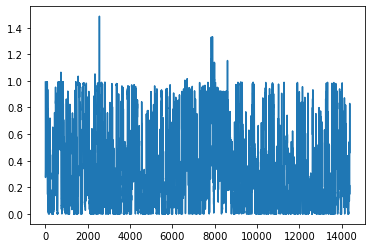

In [17]:
df = pd.read_csv("wf30.csv")
plt.plot(df["PowerGeneration"].values)
plt.show()

In [27]:
Y.shape
def transform_xy_to_multistep(X, y, h):
    res_x = np.empty([(X.shape[0] - h) * h , X.shape[1] + 1])
    res_y = np.empty([(y.shape[0] - h) * h ])

    for i in range(X.shape[0] - h):
        res_x[i * h: i * h + h, 0:X.shape[1]] = np.tile(X[i],(h,1))
        res_x[i * h: i * h + h, X.shape[1]] = np.arange(h)/h

        res_y[i * h: i * h + h] = y[i+h]
    return res_x, res_y


In [52]:
X_test_org.shape

(1024, 24)

In [55]:
df["PowerGeneration"].values.shape

(14382,)

In [60]:
X_test_org.shape

(1024, 24)

In [62]:
y_test_org.shape

(1024, 24)

In [35]:
HORIZON = 24
INPUT_SIZE = 24
N_TEST = 1000
MAX_DEPTH = 8
N_ESTIMATORS = 500



quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#quantiles = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
X, Y = sliding_window(df["PowerGeneration"].values, INPUT_SIZE, INPUT_SIZE)

X_train_org, y_train_org, X_test_org, y_test_org = train_test_split(X, Y, N_TEST+HORIZON)
X_train, y_train = transform_xy_to_multistep(X_train_org, y_train_org, HORIZON)
X_test, y_test = transform_xy_to_multistep(X_test_org, y_test_org, HORIZON)

predictions = np.empty([len(quantiles), HORIZON, N_TEST])
regressors = [{} for i in range(HORIZON)]

for i, q in enumerate(quantiles):
  reg = GradientBoostingRegressor(loss='quantile', alpha=q,
                            n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,
                            learning_rate=.01, min_samples_leaf=20,
                            min_samples_split=20).fit(X_train, y_train)
  for j in range(HORIZON):

    indx = np.where(X_test[:,INPUT_SIZE] == j/HORIZON)
    predictions[i,j,:] = reg.predict(X_test[indx])

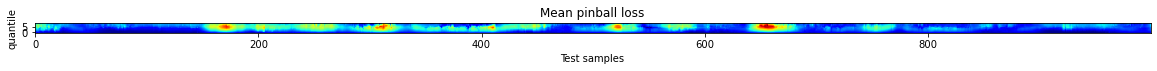

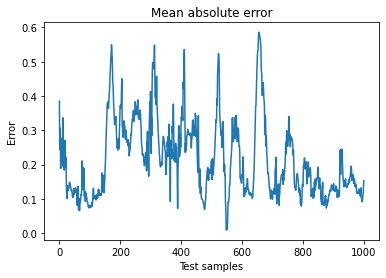

In [45]:
sorted_predictions = np.sort(predictions, axis=0)
diff = abs(np.sum((sorted_predictions == predictions) - 1))

MPL = np.zeros([len(quantiles), N_TEST])
MAE = np.zeros(N_TEST)
for j in range(N_TEST):
    
    for i, q in enumerate(quantiles):
        MPL[i, j] += mean_pinball_loss(y_test[j*HORIZON:j*HORIZON + HORIZON], sorted_predictions[i,:,j], alpha=q)
    quantile_indx = quantiles.index(0.5)
    MAE[j] += mean_absolute_error(y_test[j*HORIZON:j*HORIZON + HORIZON], sorted_predictions[quantile_indx,:,j])

    

plt.figure(figsize=(20, 20))
plt.title('Mean pinball loss')
plt.imshow(MPL, cmap='jet', origin='lower')
plt.xlabel('Test samples')
plt.ylabel('quantile')
plt.show()
plt.title('Mean absolute error')
plt.plot(MAE)
plt.xlabel('Test samples')
plt.ylabel('Error')
plt.show()

naive MPL:  0.7638681402439026
MPL:  0.7357649592753183
total differences: 4845 	size: 216000 	cross percentage: 0.022430555555555554


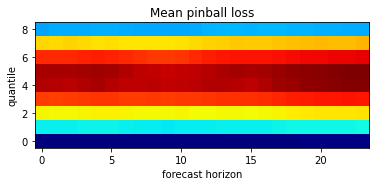

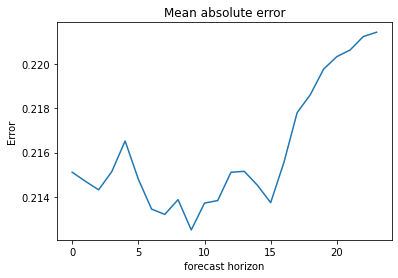

In [37]:
quantiles_lin = np.linspace(0,1,19)
yhat_quantile = np.quantile(X_train, quantiles)
MPL_naive = np.zeros([len(quantiles), HORIZON])
MPL = np.zeros([len(quantiles), HORIZON])
MAE = np.zeros(HORIZON)
quantile_indx = quantiles.index(0.5)
for j in range(HORIZON):
    
    indx = np.where(X_test[:,INPUT_SIZE] == j/HORIZON)
    for i, q in enumerate(quantiles):
        MPL_naive[i, j] += mean_pinball_loss(y_test[indx], np.full( len(y_test[indx]),yhat_quantile[i]), alpha=q)
        MPL[i, j] += mean_pinball_loss(y_test[indx], sorted_predictions[i,j,:], alpha=q)
        
    MAE[j] += mean_absolute_error(y_test[indx], sorted_predictions[quantile_indx,j,:])
print("naive MPL: ",np.sum(MPL_naive)/HORIZON)
print("MPL: ", np.sum(MPL)/HORIZON)
print("total differences:", diff, "\tsize:", sorted_predictions.size, "\tcross percentage:", diff/sorted_predictions.size)

plt.title('Mean pinball loss')
plt.imshow(MPL, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('quantile')
plt.show()
plt.title('Mean absolute error')
plt.plot(MAE)
plt.xlabel('forecast horizon')
plt.ylabel('Error')
plt.show()

In [38]:
def pinball_loss(d, f, alpha):
    return max(alpha*(d-f), (1-alpha)*(f-d))

y_true_reshaped = np.zeros(sorted_predictions.shape[1:])
quantile_diff = np.zeros(sorted_predictions.shape)

for i in range(N_TEST):
    y_true_reshaped[:,i] = y_test[i*HORIZON:i*HORIZON + HORIZON]

for i in range(N_TEST):
    for j in range(HORIZON):
        for k, q in enumerate(quantiles):
            quantile_diff[k, j, i] = pinball_loss(y_true_reshaped[j, i], sorted_predictions[k, j, i], q)


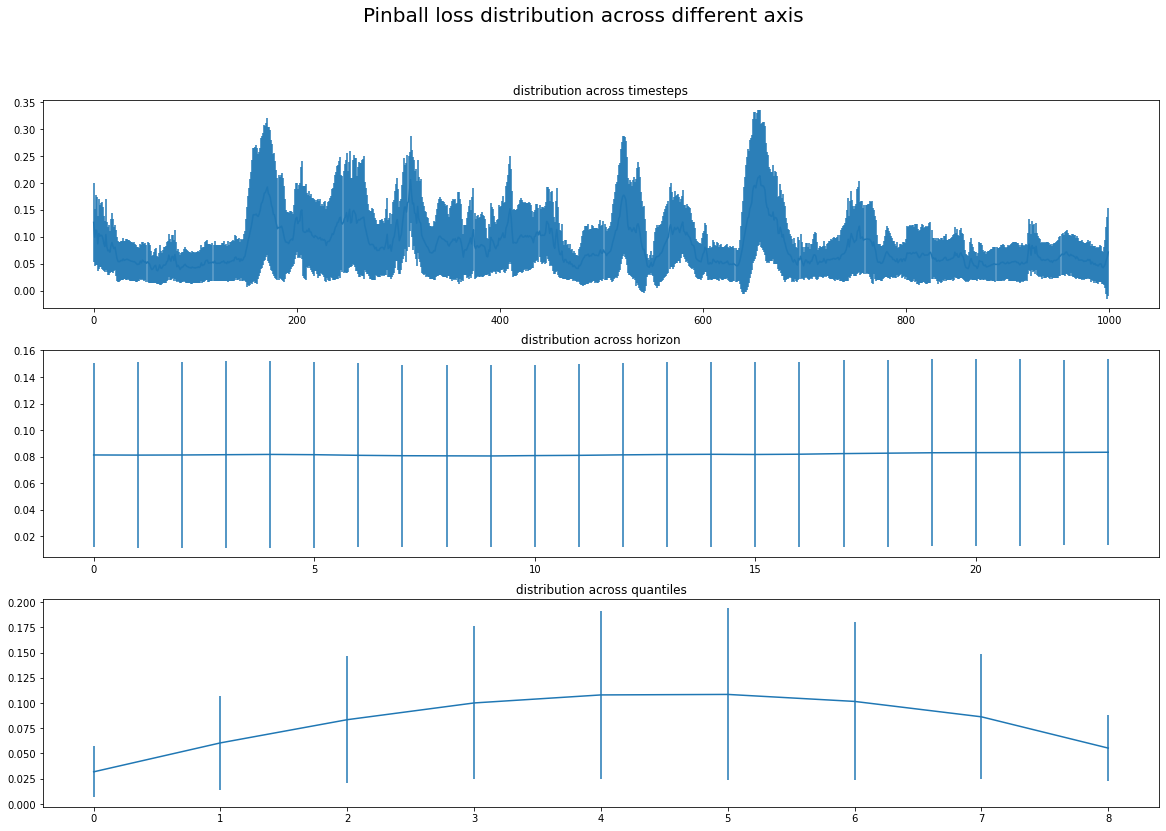

In [39]:
fig, axs = plt.subplots(3)
fig.set_size_inches(20, 13)
fig.suptitle('Pinball loss distribution across different axis', fontsize = 20)
axs[0].set_title('distribution across timesteps')
axs[0].errorbar(np.arange(quantile_diff.shape[2]), np.mean(quantile_diff, axis = (0, 1)), yerr = np.std(quantile_diff, axis = (0, 1)))
axs[1].set_title('distribution across horizon')
axs[1].errorbar(np.arange(quantile_diff.shape[1]), np.mean(quantile_diff, axis = (0, 2)), yerr = np.std(quantile_diff, axis = (0, 2)))
axs[2].set_title('distribution across quantiles')
axs[2].errorbar(np.arange(quantile_diff.shape[0]), np.mean(quantile_diff, axis = (1, 2)), yerr = np.std(quantile_diff, axis = (1, 2)))
plt.show()

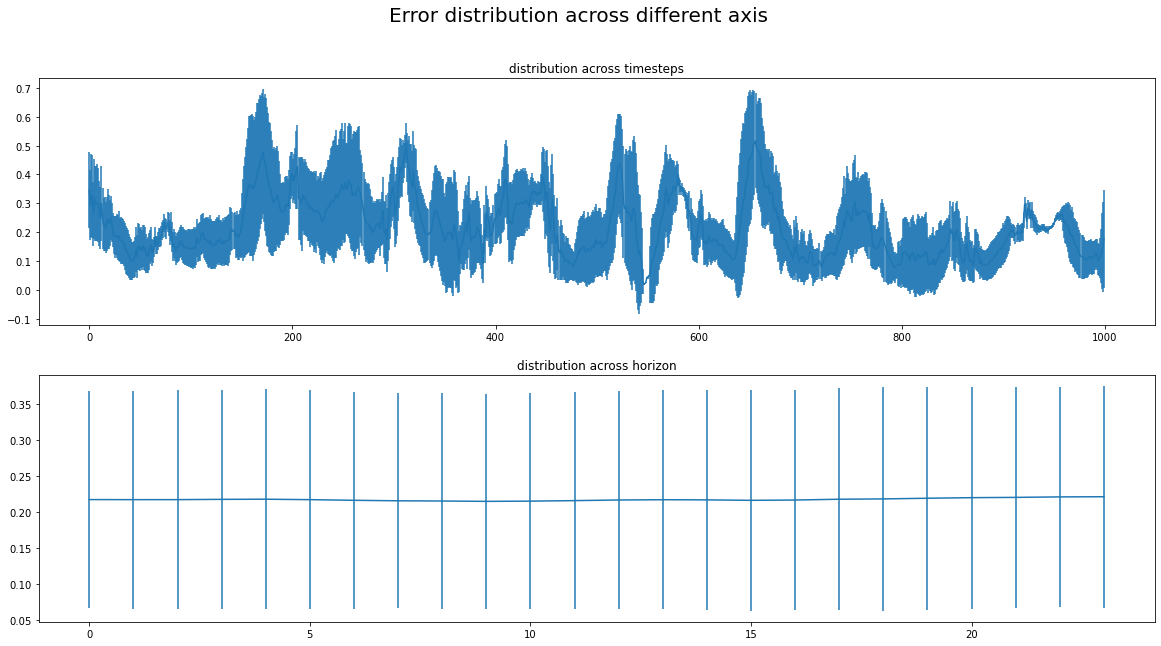

In [40]:
y_true_reshaped = np.zeros(sorted_predictions.shape[1:])

for i in range(N_TEST):
    y_true_reshaped[:,i] = y_test[i*HORIZON:i*HORIZON + HORIZON]
difference = abs(y_true_reshaped - np.mean(sorted_predictions, axis = 0))

fig, axs = plt.subplots(2)
fig.set_size_inches(20, 10)
fig.suptitle('Error distribution across different axis', fontsize = 20)
axs[0].set_title('distribution across timesteps')
axs[0].errorbar(np.arange(difference.shape[1]), np.mean(difference, axis = 0), yerr = np.std(difference, axis = 0))
axs[1].set_title('distribution across horizon')
axs[1].errorbar(np.arange(difference.shape[0]), np.mean(difference, axis = 1), yerr = np.std(difference, axis = 1))
plt.show()

In [47]:
mean = np.sum(y_train_org)/len(y_train_org)
naiveMAE = mean_absolute_error(y_test, np.full(len(y_test), mean))
print("naive MAE: ", naiveMAE)
print("model median MAE: ",mean_absolute_error(y_test, np.sum(sorted_predictions, axis = 0).flatten() / 10))

naive MAE:  8.070842158211999
model median MAE:  0.22956149344227145


In [49]:
median = np.median(y_train_org)
naiveMAE = mean_absolute_error(y_test, np.full(len(y_test), median))
print("naive MAE: ", naiveMAE)
print("model median MAE: ",mean_absolute_error(y_test, np.sum(sorted_predictions, axis = 0).flatten() / 10))

naive MAE:  0.22526920731707317
model median MAE:  0.22956149344227145


In [ ]:

N_step_plot = 3
fig, axs = plt.subplots(N_step_plot, 1)
fig.set_size_inches(10, 12)
total_quantiles = len(quantiles)-1
for i, pos in enumerate([10, 21, 78]):
    axs[i].title.set_text(str(pos+1) + ' Pos Plot')
    axs[i].plot(y_test[pos*HORIZON:pos*HORIZON+HORIZON], label = "true", linewidth=5)
    for j, q in enumerate(quantiles[:total_quantiles//2]):
        axs[i].fill_between(np.arange(HORIZON), sorted_predictions[j,:,pos], sorted_predictions[total_quantiles-j,:,pos], color='red', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
idx = np.arange(N_TEST-HORIZON)
np.random.shuffle(idx)

cov_matrix = np.identity(HORIZON)

for i in idx:
    cov_matrix = update_cov_matrix(df_y_pred_q=predictions[:,:,i], quantiles=quantiles, 
                      actual_data=y_test[i:i+HORIZON], forget_factor=0.9, cov_matrix=cov_matrix)
    
plt.imshow(cov_matrix, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')

plt.show()

In [ ]:
def  sample_from_quantiles(df_y_pred_q, quantiles, n_scenarios, cov_matrix = [], rnd_seed = [], sort = "No", debug=False):
    n_periods = np.size(df_y_pred_q,0)
    
    if np.size(cov_matrix,0) == 0:
        cov_matrix = np.identity(n_periods)
    if np.size(rnd_seed,0) != 0:        
        np.random.seed(rnd_seed)

    
    mean_vector = np.zeros(n_periods)
    std_vector = np.sqrt(np.diagonal(cov_matrix))
    print(mean_vector.shape)
    # Normalize covariance matrix    
    cov_matrix = cov_matrix / np.outer(std_vector,std_vector)
    if debug:
        print('covariance matrix')
        print(cov_matrix)
    
    # Generate multivariate Gaussian random numbers with zero mean and covariance matrix
    X = np.random.multivariate_normal(mean_vector, cov_matrix, n_scenarios)
    # Sort
    if sort == "Yes": 
        X = np.sort(X, axis=0)
    # Gaussian --> Uniform transformation
    Y = scp.stats.norm.cdf(X)
    
    # Plot hist of X (normal) and Y(uniform)
    if debug:
        bin_cnt = 200
        plt.hist(X[:,0],bin_cnt)
        plt.show()
        plt.hist(Y[:,0],bin_cnt)
        plt.show()

    # Calculate interpolation function
    Finv = scp.interpolate.interp1d(quantiles, df_y_pred_q, kind='quadratic', axis=1, bounds_error=False, fill_value="extrapolate")
    
   
    columns = ['scenario{0}'.format(int(i)) for i in range(n_scenarios)]
    scenarios = pd.DataFrame(index=np.arange(df_y_pred_q.shape[0]), columns=columns)
    for i in range(n_periods):
        scenarios.iloc[i] = Finv(Y[:,i])[i,:]
    
    
    # Print CDF and scenarios    
    if debug:
        for i in range(n_periods):
            plt.plot(df_y_pred_q.iloc[i], quantiles, 'o', scenarios.iloc[i], Y[:,i], 'x')
            plt.show()
   
    return scenarios


In [ ]:
generated_scenarios = sample_from_quantiles(df_y_pred_q=sorted_predictions[:,:,-1].T, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=100, rnd_seed=[0], sort=True)

In [ ]:
plt.plot(generated_scenarios.values, color='k', alpha=0.25)
plt.plot(generated_scenarios.values.mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(y_test[-HORIZON:], color='red', linewidth=4)
plt.show()

In [ ]:
plt.boxplot(generated_scenarios.T)
plt.show()

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

for i in range(HORIZON):
    sns.distplot(generated_scenarios.values[i])
    plt.show()

In [ ]:
plt.boxplot(generated_scenarios.T)
plt.show()

In [ ]:
import dcor
MAE = mean_absolute_error(y_test[-HORIZON:], generated_scenarios.values.mean(axis=1))
energy = dcor.energy_distance(generated_scenarios.T, y_test[-HORIZON:])
print("MAE scenarios:", MAE, "Energy distance:", energy)